In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])

from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
cm  = plt.get_cmap('cividis')
def sin_func(t, A, f0, phi, B):
    return A*np.sin(2*np.pi*f0*t-phi) + B

def exp_decay(x, a, b, c):
    return a*np.exp(-x/b) + c

In [38]:
stat_size           = 50
N_periods           = 20
time_step           = 1e-9
N_p                 = 9
N_eq_p              = 10
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                        [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                        [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                        'constant','constant','constant','floating']
}

folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/ac_input_vs_freq/"
freq_vals   = [80e3,120e3,160e3,240e3,320e3,480e3,640e3,960e3,1280e3,1920e3,2560e3,3840e3,5120e3]
time_data   = {}
U0_data     = {}
data        = {}
pot_data    = {}
for f0 in freq_vals:
    frequencies         = [f0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    amplitudes          = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    T_sim               = N_periods/f0
    N_volt              = int(T_sim/time_step)
    time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_volt, topology_parameter, amplitudes=amplitudes, frequencies=frequencies, time_step=time_step)
    data[f0]            = pd.read_csv(f"{folder}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{int(f0)}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    pot_data[f0]        = pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{int(f0)}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    time_data[f0]       = time_steps[:len(data[f0])]
    U0_data[f0]         = volt[N_eq_p*N_volt//N_periods:-1,0]

In [39]:
N_f         = 50
h_strength  = []
thd         = []
A_f0        = []
phase       = []
freq_fit    = []

for f0 in freq_vals:
    h1  = []
    t1  = []
    A1  = []
    p1  = []
    f1  = []
    p0  = [0.1, f0, 0, 0]
    for i in range(N_p*N_p+1):
        t_val   = time_data[f0]
        y_val   = pot_data[f0].iloc[:,i].values.copy()*1000
        h_temp  = nanonets_utils.harmonic_strength(signal=y_val, f0=f0, dt=time_step, N_f=N_f, n_padded=len(y_val)*10, dB=False)
        xf,yf   = nanonets_utils.fft(y_val, time_step, n_padded=len(y_val)*10)
        func    = interp1d(xf, yf)
        A2      = float(func(f0))
        p,_     = curve_fit(sin_func, t_val, y_val, p0=p0, bounds=[(0,f0-0.1,-np.inf,-np.inf),(0.2,f0+0.1,np.inf,np.inf)])
        p0      = [p[0],f0,p[2],p[3]]

        h1.append(h_temp)
        t1.append(np.sqrt(np.sum(np.array(h_temp)**2))*100)
        A1.append(A2)
        f1.append(p[1]/1e6)
        p1.append(p[2])
    A_f0.append(A1)
    h_strength.append(h1)
    thd.append(t1)
    phase.append(p1)
    freq_fit.append(f1)

thd_df  = pd.DataFrame(thd, index=np.round(np.array(freq_vals)*1e-6,2))
A_f0_df = pd.DataFrame(A_f0, index=np.round(np.array(freq_vals)*1e-6,2))
pha_df  = pd.DataFrame(phase, index=np.round(np.array(freq_vals)*1e-6,2))

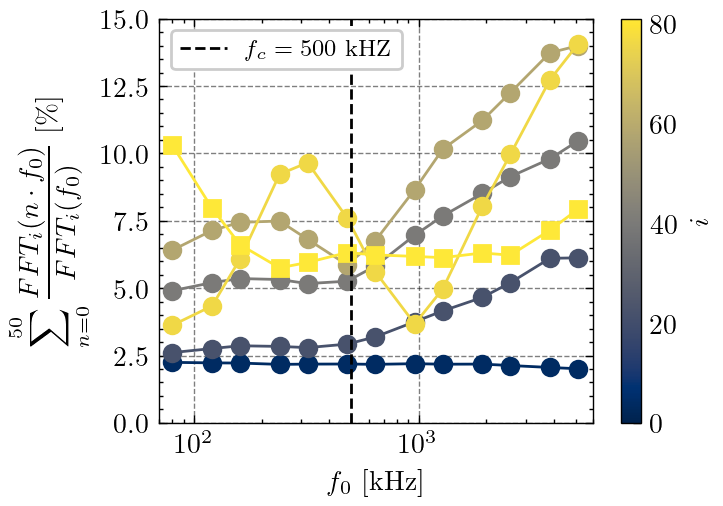

In [82]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=81)
for i in range(0,9,2):
    ax.plot(np.array(freq_vals)/1e3, thd_df.iloc[:,i*9+4].values, '-o', color=cm(norm(i*9+4)))
ax.plot(np.array(freq_vals)/1e3, thd_df.iloc[:,81].values, '-s', color=cm(norm(81)))
ax.set_xscale('log')
ax.set_ylabel("$\displaystyle\sum_{n=0}^{50}\\frac{FFT_i(n \cdot f_0)}{FFT_i(f_0)}$ [\%]")
ax.set_xlabel("$f_0$ [kHz]")
ax.vlines(500,0,20, colors='black', ls='--', label="$f_c = 500$ kHZ")
ax.legend(fontsize='small', loc='upper left')

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")
ax.set_xlim(70,6000)
ax.set_ylim(0,15)

fig.savefig("../plots/ac_input/thd_vs_freq.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

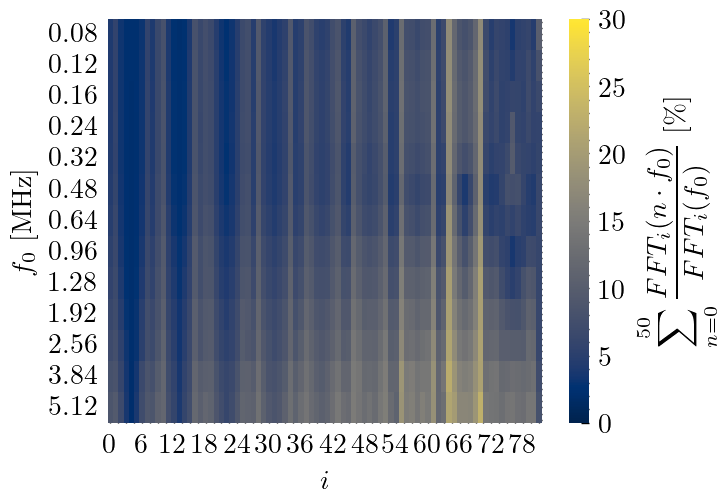

In [43]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(thd_df, cmap='cividis', ax=ax, vmin=0, vmax=30, # center=0, 
                  cbar_kws={"label":"$\displaystyle\sum_{n=0}^{50}\\frac{FFT_i(n \cdot f_0)}{FFT_i(f_0)}$ [\%]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/thd_vs_f0_vs_i.svg", transparent=True)

In [ ]:
params      = []
params_st   = []
taus        = []
taus_st     = []

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(exp_saturation, t_vals, y, p0=[key, U_0*100], bounds=[(0,U_0*100-0.1),(np.inf,U_0*100+0.1)])
    params.append(p)
    taus.append(p[0])

cap_vals_t  = np.array(cap_vals).copy()
cap_vals_t  = np.round(radius_to_capacitance(np.array(cap_vals)))
cap_log     = np.log(cap_vals_t[3:])
tau_log     = np.log(taus[3:])
B, log_A    = np.polyfit(cap_log, tau_log, 1)
A2,_        = curve_fit(linear_func, cap_vals_t[3:], taus[3:])
A           = np.exp(log_A)

In [ ]:
taus

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, taus, 'o', label='$U_1 \propto (1-\exp^{-t/\\tau})$')
# ax.plot(cap_vals_t, 1.7 * cap_vals_t**1, label=f'$\\tau \propto C$')
ax.plot(cap_vals_t, A2 * cap_vals_t, label=f'$\\tau \propto C$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('$\\tau$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')

# fig.savefig("../plots/dc_input/time_scale_vs_cap.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, streched_moments(taus, betas), 'o', label='$<\\tau> \propto C^{\\beta}$')
ax.plot(cap_vals_t, A * cap_vals_t**B, label=f'$\\beta = {np.round(B,2)}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('$<\\tau>$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')

# fig.savefig("../plots/dc_input/output_time_scale_vs_cap.svg", transparent=True)
# fig.savefig("../plots/dc_input/output_time_scale_vs_cap.pdf", transparent=False)

In [ ]:
1/(2*np.pi)

In [ ]:
A * 5e3 ** B

In [ ]:
50000*1e-10*1e9

In [ ]:
1e6/(2*np.pi*4000)

In [ ]:
1e3/(2*np.pi*20)

## Two Step Input

In [ ]:
N_voltages      = 200000
steps_between_s = [0,400,800,1600,2000,4000,5000,10000,20000,40000]
steps_per_step  = 40000
time_step       = 1e-10
cap             = 5e3
t_vals          = np.arange(N_voltages-1)*1e-10*1e6
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/two_step_input/"
data_two        = {steps : pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{steps}.csv") for steps in steps_between_s}

In [ ]:
steps_between   = 40000
df              = data_two[steps_between].copy()
fuc = stretched_exp_saturation
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000
y1  = y[:steps_per_step].copy()
y2  = y[steps_per_step+steps_between:2*steps_per_step+steps_between].copy()
y1  -= y1[0]
y2  -= y2[0]

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]')
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
p,c = curve_fit(fuc, t_vals[:len(y1)],y1, p0=[2,100,1])
print(p)
print(streched_moments(p[0],p[2]))
p1  = ax.plot(t_vals[:len(y1)],y1, 'o', markevery=2000, ms=5)
# ax.plot(t_vals[:len(y1)],fuc(t_vals[:len(y1)],*p), color=p1[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.plot(t_vals[:len(y1)],fuc(t_vals[:len(y1)],*p), color=p1[0].get_color(), label=f'$\\tau = {np.round(streched_moments(p[0],p[2]),2)}$ $\mu$s')

p,c = curve_fit(fuc, t_vals[:len(y2)],y2, p0=[2,50,1])#, bounds=[(0,0,0),(200,np.inf,1)])
print(p)
print(streched_moments(p[0],p[2]))
p2  = ax.plot(t_vals[:len(y2)],y2, 's', markevery=2000, ms=5)
# ax.plot(t_vals[:len(y2)],fuc(t_vals[:len(y2)],*p), color=p2[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.plot(t_vals[:len(y2)],fuc(t_vals[:len(y2)],*p), color=p2[0].get_color(), label=f'$\\tau = {np.round(streched_moments(p[0],p[2]),2)}$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend()

fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.svg", transparent=True)
fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.pdf", transparent=False)

## Increasing Steps

In [ ]:
steps_per_step  = 40000
cap             = 5e3
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/increasing_steps/"
df              = pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") 
N_voltages      = len(df)
time_step       = 1e-10
t_vals          = np.arange(N_voltages)*1e-10*1e6

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]', color=nanonets_utils.blue_color)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
for i in range(1,11):
    y1  =   y[i*steps_per_step:(i+1)*steps_per_step].copy()
    y1  -=  y1[0]
    p,c = curve_fit(exp_saturation, t_vals[:len(y1)], y1)
    print(p)
    p1  = ax.plot(t_vals[:len(y1)], y1, 'o', markevery=2000, ms=5)
    ax.plot(t_vals[:len(y1)], exp_saturation(t_vals[:len(y1)], *p), color=p1[0].get_color(),
            label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(fontsize='xx-small', ncol=2)
ax.set_ylim(-30,30)

fig.savefig(f"../plots/increasing_steps.svg", transparent=True)
fig.savefig(f"../plots/increasing_steps.pdf", transparent=False)

In [ ]:
N_voltages  = 1000000
time_step   = 1e-9
U_0         = 0.1
time_steps  = np.arange(N_voltages)*time_step
f0          = 40e3
f1          = 140e3
U_i         = U_0*np.sin(2*np.pi*f0*time_steps) + U_0*np.sin(2*np.pi*f1*time_steps)
plt.plot(U_i)

In [ ]:
y1              = y[:steps_per_step]
y2              = y[steps_per_step+steps_between:2*steps_per_step+steps_between]

In [ ]:
plt.plot(y1)
plt.plot(y2)

In [ ]:
t_at_68 = []
U_th    = U_0*0.1 #U_0*0.63

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > U_th)[0][0]])

t_at_68

In [ ]:
steps_per_step  = 50000
U_step          = 0.01
U_i1            = U_step*np.repeat(np.arange(6),steps_per_step)
U_i2            = U_step*np.repeat(np.arange(4,-1,-1),steps_per_step)
U_i             = np.hstack((U_i1,U_i2))
plt.plot(U_i)

In [ ]:
steps_per_step  = 10
steps_between   = 10
start           = 0
U_step          = 0.01
N_voltages      = 100
U_i                                                                             = np.zeros(N_voltages)
U_i[start:steps_per_step]                                                       = U_step
U_i[start+steps_per_step+steps_between:start+2*steps_per_step+steps_between]    = U_step

plt.plot(U_i)

In [ ]:
fig = plt.figure(dpi=200)
ax2 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    p   = pot_cap[key]['9']*1000
    ax2.plot(t_vals, p)

ax2.set_yscale('log')
ax2.set_ylim(5e0,2e2)
ax2.set_xscale('log')
ax2.set_xlim(10,np.max(t_vals))
ax2.set_ylabel('$\phi_9$ [mV]')
ax2.set_xlabel('$t$ [ns]')

In [ ]:
t_at_68 = []

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > 0.068)[0][0]])

In [ ]:
plt.plot(t_at_68)

In [ ]:
def exp_saturation(x, tau, a0):
    return a0*(1 - np.exp(-x/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, alpha, beta, a0):
    return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)

In [ ]:
params  = []
stds    = []
func    = exp_power_law_saturation
p0      = [100, 1, 100]

fig = plt.figure(dpi=300)
ax  = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(func, t_vals, y, maxfev=2000, p0=[key, 10, 1, 1, 1])
    pl  = ax.plot(t_vals, y, '.', ms=1)
    ax.plot(t_vals, func(t_vals, *p), c=pl[0].get_color())

    params.append(p)
    stds.append(np.sqrt(c[0,0]))

    print(p)

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e3)
ax.set_xlim(0,50)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')